# Hyperparameter optimization of scikit-learn algorithms

In this notebook, we optimize the hyperparameters of the scikit-learn algorithms using Scikit-Optimize.

Scikit-Optimize seems to be not maintained anymore, but it was still good to perform hyperparameter search through Bayesian optimization.

In [1]:
#!/usr/bin/env python
# coding: utf-8
# (c) Charles Le Losq, Clément Ferraina 2023
# see embedded licence file
# iVisc 1.0

#
# Library Loading
#
import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import numpy as np
np.random.seed = 167 # fix random seed for reproducibility

import time, os

# local imports
import src.utils as utils
#import src.ivisc as ivisc

# import sklearn models
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.metrics.pairwise import rbf_kernel
from sklearn. preprocessing import StandardScaler

# import sklearn utils
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit

#from tqdm import tqdm

# import joblib (save and load models)
import joblib

#
# Helper function for performance evaluation
#
def evaluate_model(ds, model, model_name="Don't forget this..."):

    y_train_pred = model.predict(ds.TPX_train_scaled)
    y_valid_pred = model.predict(ds.TPX_valid_scaled)

    mse_train = root_mean_squared_error(ds.y_train, y_train_pred)
    mse_valid = root_mean_squared_error(ds.y_valid, y_valid_pred)

    r2_train = r2_score(ds.y_train, y_train_pred)
    r2_valid = r2_score(ds.y_valid, y_valid_pred)

    #Stats data
    print(model_name)
    print('Root Mean Square Errors:','\n',
          'Train    %.2f' % mse_train,'\n',
          'Valid     %.2f' % mse_valid,'\n'
          'Coefficient of Determination:','\n',
          'Train    %.2f' % r2_train,'\n',
          'Valid     %.2f' % r2_valid
         )

/tmp/ipykernel_970674/54495791.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # manipulate dataframes


# Data loading

We use utils.data_loader to load the data for training the black box models.

In [2]:
# Data loading
print("Loading the viscosity datasets...")
ds = utils.data_loader(path_viscosity='./data/all_viscosity.hdf5')
print("Loaded.")

Loading the viscosity datasets...
Loaded.


## further data preparation

Upon hyperparameter optimization, we keep a validation dataset. It is implemented in the cell below, we keep the indices of the validation subset.

In [3]:
# we first scale the data only using metrics on the train dataset
# preparing data scaling
scaler = StandardScaler().fit(ds.TPX_train)
ds.TPX_train_scaled = scaler.transform(ds.TPX_train)
ds.TPX_valid_scaled = scaler.transform(ds.TPX_valid)

# the algorithm below wants to perform CV search
# we avoid this, as we want to use the validation dataset
# to do so, we will fix the folds for the validation dataset
X_ = np.vstack((ds.TPX_train_scaled, ds.TPX_valid_scaled))
Y_ = np.vstack((ds.y_train, ds.y_valid))
splits = np.ones(len(X_))
splits[:len(ds.TPX_train_scaled)] = -1
ps = PredefinedSplit(test_fold = splits)

#### Support Vector Machine regression

Here we need to tune two hyperparameters, C and epsilon. For doing so, we show how we used skopt to find the best hyperparameters rapidly.

In [6]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score

#workaround for scikit-optimize problem with np.int
np.int = np.int64

In [7]:
# model
reg = SVR(kernel = 'rbf')

# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(1, 1000, name='C'),
          Real(10**-4, 10**2, "log-uniform", name="epsilon")]

#parameters = {'C':[1,10,100,1000], 'epsilon':[0.001,0.01,0.1,1,10]} #[1,5,6,7,8,9,10,11,12,13,14,15, 25,50, 100]
#Grid = GridSearchCV(SVR(kernel = 'rbf'), parameters, cv=ps)
#Grid.fit(X_, Y_.ravel())

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X_, Y_.ravel(), cv=ps, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)

"Best score=%.4f" % res_gp.fun

'Best score=0.3437'

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

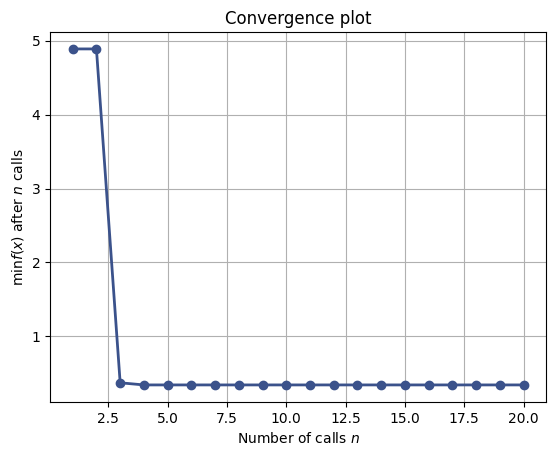

In [8]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

In [9]:
print("""Best parameters:
- C=%d
- epsilon=%.6f""" % (res_gp.x[0], res_gp.x[1]))


Best parameters:
- C=298
- epsilon=0.000219


Train a SVR model with the best hyperparameters

# Artificial neural network

The architecture of the ANN was tuned by hand. The default learning rate already allows obtaining reasonable results with minimal overfitting, such that we did not search to tune it further.

In [12]:
# train a neural network
clf_nn = MLPRegressor(solver='adam', alpha=1e-3, hidden_layer_sizes=(200,200),
                    random_state=1, activation='relu', max_iter=10000
                   )

clf_nn.fit(ds.TPX_train_scaled, ds.y_train.ravel())

MLPRegressor(alpha=0.001, hidden_layer_sizes=(200, 200), max_iter=10000,
             random_state=1)

In [13]:
evaluate_model(ds, clf_nn, model_name = "ANN REGRESSION")

ANN REGRESSION
Root Mean Square Errors: 
 Train    0.34 
 Valid     0.48 
Coefficient of Determination: 
 Train    0.99 
 Valid     0.99


# Random Forest

In [ ]:
#workaround for scikit-optimize problem with np.int
np.int = np.int64
clf_xgb = RandomForestRegressor()

# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(1, 200, name="n_estimators"),
          Integer(1, 20, name='max_depth'),
          Integer(2, 10, name="min_samples_split"),
          Integer(1,10, name="min_samples_leaf")]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space)
def objective(**params):
    clf_xgb.set_params(**params)

    return -np.mean(cross_val_score(clf_xgb, X_, Y_.ravel(), cv=ps, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=40, random_state=0)

"Best score=%.4f" % res_gp.fun


In [ ]:
res_gp.x

In [ ]:
from skopt.plots import plot_convergence
plot_convergence(res_gp)

print("""Best parameters:
- n_estimators=%d
- max_depth=%d
-min_samples_split=%d
-min_samples_leaf=%d""" % (res_gp.x[0],res_gp.x[1],res_gp.x[2],res_gp.x[3]))


In [14]:
clf_rf = RandomForestRegressor(
    n_estimators = 149,
    max_depth = 20,
    min_samples_split = 2,
    min_samples_leaf = 1).fit(ds.TPX_train_scaled, ds.y_train.ravel())

In [15]:
evaluate_model(ds, clf_rf, model_name = "Random Forest REGRESSOR")

Random Forest REGRESSOR
Root Mean Square Errors: 
 Train    0.12 
 Valid     0.38 
Coefficient of Determination: 
 Train    1.00 
 Valid     0.99
